In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import gurobipy as gp
from gurobipy import GRB
import math, time
from tqdm import tqdm
from matplotlib import pyplot as plt

In [ ]:
names = locals()
cement_plant_list = pd.read_csv('../data/plants_in_2020.csv', index_col=0)
Wang_2023_clinker = pd.read_excel('../data/Wang_2023.xlsx', sheet_name='Clinker - production output')
parameters = pd.read_excel('../data/20241220.xlsx', index_col=0)

China_provinces = gpd.read_file('../data/China-maps/province.shp')
China_boundary = gpd.read_file('../data/China-maps/boundary.shp')
China_counties = gpd.read_file('../data/China-maps/county.shp')
China_provinces2 = gpd.read_file('../data/China-maps-simplified/province.shp')
China_counties2 = gpd.read_file('../data/China-maps-simplified/county.shp')
China_provinces['geometry'] = China_provinces2['geometry']
China_counties['geometry'] = China_counties2['geometry']
China_counties = China_counties.drop([176, 638, 639, 2403])

China_provinces = China_provinces.to_crs(2381)
China_boundary = China_boundary.to_crs(2381)
China_counties = China_counties.to_crs(2381)

county_shortest_distances = pd.read_csv('../data/shortest_distances_matrix.csv', index_col=0)
county_shortest_distances = county_shortest_distances.drop([176, 638, 639, 2403])
county_shortest_distances = county_shortest_distances.drop(['176', '638', '639', '2403'], axis=1)
county_distance_matrix = county_shortest_distances.values

In [35]:
future_county_cement_POP = pd.read_csv('../outputs/China_county_cement_POP_SSP2.csv', index_col=2)
future_county_cement_GDP = pd.read_csv('../outputs/China_county_cement_GDP_SSP2.csv', index_col=2)
future_county_cement_combined = pd.read_csv('../outputs/China_county_cement_combined_SSP2.csv', index_col=2)

In [18]:
future_county_cement_POP

,省,市,县代码,2020,2025,2030,2035,2040,2045,2050
县,,,,,,,,,,
大观区,安徽省,安庆市,340803.0,365.532824,276.093298,219.411828,183.117611,161.059663,144.196094,130.911009
怀宁县,安徽省,安庆市,340822.0,956.569749,723.847494,574.416286,478.389488,419.794140,374.822227,339.978066
潜山市,安徽省,安庆市,340882.0,883.543716,658.749894,516.596245,426.303650,371.106543,329.617922,296.452804
宿松县,安徽省,安庆市,340826.0,1054.443315,790.558962,622.258592,515.529579,450.535114,401.849647,363.819506
太湖县,安徽省,安庆市,340825.0,875.751324,649.165168,506.802509,416.125602,359.876300,317.959489,284.816776
...,...,...,...,...,...,...,...,...,...,...
桐庐县,浙江省,杭州市,330122.0,743.290561,553.773382,434.625785,359.755687,313.159799,277.641045,249.686856
西湖区,浙江省,杭州市,330106.0,1737.205044,1334.346304,1071.814471,900.285097,792.894994,708.248645,643.292447
萧山区,浙江省,杭州市,330109.0,2755.227755,2131.331194,1724.323638,1460.421115,1298.517057,1170.762908,1071.087612


In [19]:
class Line:
    def __init__(self, capacity, open_year):
        self.capacity = capacity
        self.annual_capacity = round(self.capacity * 330 / 10**3, 2)      # unit: kt clinker / year 
        self.open_year = open_year
        self.production = 0
        self.u_rate = 0
        self.in_operation = 1

        t0 = 2020
        self.age = (t0 - self.open_year) if (t0 - self.open_year) < 40 else (t0 - self.open_year) - np.random.randint(1, 5)
        self.results_production = pd.Series([0 for yr in range(2020, 2065, 5)], index=[yr for yr in range(2020, 2065, 5)], dtype=np.float32)
        self.results_urate = pd.Series([0 for yr in range(2020, 2065, 5)], index=[yr for yr in range(2020, 2065, 5)], dtype=np.float32)
        self.results_retired = pd.Series([0 for yr in range(2020, 2065, 5)], index=[yr for yr in range(2020, 2065, 5)], dtype=np.float32)
        self.results_shutdown = pd.Series([0 for yr in range(2020, 2065, 5)], index=[yr for yr in range(2020, 2065, 5)], dtype=np.float32)  

    
    def update(self, t):
        if self.in_operation == 0:
            pass
        else:
            if t > 2020: 
                self.age = t - self.open_year
            else:
                pass

            if self.age > 40:
                self.in_operation = 0
                self.results_retired[t] = 1 
            else:
                pass
            
    
    def update2(self, t): 
        self.u_rate = round(self.production / max(self.annual_capacity, 0.0001), 2) 
        self.results_urate[t] = np.float32(self.u_rate)
        self.results_production[t] = round(np.float32(self.production), 1) 

        if t >= 2025: 
            if (self.results_urate[[t-5, t]].mean() <= 0.3) & (self.age >= 20): 
                self.in_operation = 0 
                self.results_shutdown[t] = 1 
            else:
                pass
        else:
            pass

In [20]:
class County:
    def __init__(self, name):
        self.name = name
        self.a_slice = cement_plant_list[(cement_plant_list['县'] == self.name) & (cement_plant_list['in_operation'] == 1)]
        # self.city = self.a_slice['市'].values[0]
        self.old_line_set = [Line(a, b) for a, b in zip(self.a_slice['real_capacity'], self.a_slice['open_year'])]
        self.new_line_set = []
    
        self.capacity = sum([a_line.annual_capacity * a_line.in_operation for a_line in self.old_line_set])    # unit: kt clinker/year 
        self.production = 0
        self.u_rate = 0
        self.retired_capacity = 0
        self.shutdown_capacity = 0
        self.in_operation = 1 

        self.gap = 0

        # self.results = pd.DataFrame([], columns=['capacity', 'retired', 'shutdown', 'new', 'old', 'urate', 'production'], dtype=np.float32)
        self.results = pd.DataFrame([], columns=['capacity', 'retired', 'shutdown', 'new', 'old', 'urate', 'production']) 

    def update(self, t):
        for a_line in self.old_line_set + self.new_line_set:
            if a_line.in_operation == 1:
                a_line.update(t)
            else:
                pass
    
        self.capacity = sum([a_line.annual_capacity * a_line.in_operation for a_line in self.old_line_set + self.new_line_set])    # unit: kt clinker/year 

        self.retired_capacity = sum([a_line.annual_capacity * a_line.results_retired[t] for a_line in self.old_line_set + self.new_line_set])   # those capacity that retires in this year. 
            

    def build_new_lines(self, t, available_capacity):
        available_daily_capacity = math.ceil(available_capacity/330) * 1000     # unit: kt 
        num_5000 = (available_daily_capacity // 5000) if (available_daily_capacity % 5000) <= 3000 else (available_daily_capacity // 5000) +1 
        num_3000 = 1 if (available_daily_capacity % 5000) <= 3000 else 0
        
        for j in range(num_5000):
            self.new_line_set.append(Line(5000, t))

        for k in range(num_3000):
            self.new_line_set.append(Line(3000, t))

        self.capacity = sum([a_line.annual_capacity * a_line.in_operation for a_line in self.old_line_set + self.new_line_set])    # unit: kt clinker/year 

    def calculate_score(self, a_line, max_capacity=12000, max_age=40):
        normalized_capacity = a_line.capacity / max_capacity
        normalized_age = max((max_age - a_line.age) / max_age, 0)
        score = (normalized_capacity + normalized_age) / 2

        return round(score, 3)

    def allocate_production(self, a_production, original_line_set):
        candidate_line_set = []
        for a_line in original_line_set:
            if a_line.in_operation == 1:
                candidate_line_set.append(a_line)

        self.ranked_lines = sorted(candidate_line_set, key=lambda line:self.calculate_score(line), reverse=True)
        remaining_production = a_production
        for a_line in self.ranked_lines:
            if remaining_production > 0:
                allocated = min(remaining_production, a_line.annual_capacity)
                a_line.production = allocated 
                remaining_production -= allocated
            else:
                a_line.production = 0

    
    def compile(self, t):
        for a_line in self.old_line_set + self.new_line_set:
            a_line.update2(t)
        
        self.old_capacity = sum([a_line.annual_capacity * a_line.in_operation for a_line in self.old_line_set])    # unit: kt clinker/year 
        self.new_capacity = sum([a_line.annual_capacity * a_line.in_operation for a_line in self.new_line_set])    # unit: kt clinker/year 
        self.shutdown_capacity = sum([a_line.annual_capacity * a_line.results_shutdown[t] for a_line in self.old_line_set + self.new_line_set])   # those capacity that retires in this year.
        self.capacity = sum([a_line.annual_capacity * a_line.in_operation for a_line in self.old_line_set + self.new_line_set])    # unit: kt clinker/year  

        self.u_rate = round(self.production / max(self.capacity, 0.0001), 2)


        self.results.loc[t, ['capacity', 'retired', 'shutdown', 'new', 'old']] = [self.capacity, self.retired_capacity, self.shutdown_capacity, self.new_capacity, self.old_capacity]
        # self.results.loc[t, 'production'] = round(self.production.astype(np.float32), 1) 
        self.results.loc[t, 'production'] = round(self.production, 1) 
        # self.results.loc[t, 'urate'] = self.u_rate.astype(np.float32) 
        self.results.loc[t, 'urate'] = round(self.u_rate, 3)

In [21]:
def supply_demand_matching(df_capacity, df_demand, distances_matrix): 
    # Convert inputs to NumPy arrays for fast matrix operations
    capacities_ = df_capacity.values
    capacities = capacities_[capacities_ > 0] 
    producers = np.where(capacities_ > 0)[0].tolist()

    demands_ = df_demand.values
    demands = demands_[demands_ > 0]
    markets = np.where(demands_ > 0)[0].tolist()

    num_producers = len(producers)
    num_markets = len(markets)
    
    # Set the maximum distance for local supply in the first stage
    max_local_distance = 1000
    # distances_matrix = distances_matrix[producers, markets] 
    distances_matrix = distances_matrix[producers][:, markets] 
    local_mask = distances_matrix <= max_local_distance
    
    # ----------------------------- Stage 1a: Maximize Local Supply -----------------------------
    time_1 = time.time()
    # Initialize the Gurobi model for Stage 1a
    model_stage1a = gp.Model("Cement_Plant_Distribution_Stage1_MaxSupply")
    
    # Decision variable matrix: shipment_stage1[i, j] is the shipment from plant i to market j
    shipment_stage1 = model_stage1a.addMVar((num_producers, num_markets), vtype=GRB.CONTINUOUS, name="shipment_stage1")

    # Objective: Maximize local supply (only considering local distances)
    model_stage1a.setObjective((shipment_stage1 * local_mask).sum(), GRB.MAXIMIZE)

    # Constraint 1: Plant capacity should not be exceeded
    model_stage1a.addConstr(shipment_stage1.sum(axis=1) <= capacities, name="Capacity_Constraint_Stage1a")

    # Constraint 2: Market demands should be satisfied within local constraints
    model_stage1a.addConstr((shipment_stage1 * local_mask).sum(axis=0) <= demands, name="Demand_Constraint_Stage1a")

    # Optimize Stage 1a 
    # model_stage1a.setParam("MIPGap", 0.01)
    model_stage1a.optimize()
    if model_stage1a.status == GRB.OPTIMAL:
        print("Successful optimization for Stage 1a")
    max_local_supply = shipment_stage1.X.sum()  # Total local supply

    # ----------------------------- Stage 1b: Minimize Distance with Max Local Supply -----------------------------
    time_2 = time.time()
    print(f'Time 1: {round(time_2 - time_1, 1)}')
    # Initialize the Gurobi model for Stage 1b
    model_stage1b = gp.Model("Cement_Plant_Distribution_Stage1_MinDist")
    
    # Decision variable matrix: shipment_stage1 in Stage 1b (reused)
    shipment_stage1b = model_stage1b.addMVar((num_producers, num_markets), vtype=GRB.CONTINUOUS, name="shipment_stage1b")
    
    # Objective: Minimize the shipment distance for local supply
    model_stage1b.setObjective((shipment_stage1b * distances_matrix * local_mask).sum(), GRB.MINIMIZE)

    # Constraint 1: Plant capacity should not be exceeded
    model_stage1b.addConstr(shipment_stage1b.sum(axis=1) <= capacities, name="Capacity_Constraint_Stage1b")

    # Constraint 2: Market demands should be satisfied within local constraints
    model_stage1b.addConstr((shipment_stage1b * local_mask).sum(axis=0) <= demands, name="Demand_Constraint_Stage1b")

    # Constraint 3: Ensure that the total shipment matches the maximum local supply found in Stage 1a
    model_stage1b.addConstr((shipment_stage1b * local_mask).sum() == max_local_supply, name="Max_Local_Supply_Constraint") 

    # Optimize Stage 1b
    # model_stage1b.setParam("MIPGap", 0.01)
    model_stage1b.optimize()
    if model_stage1b.status == GRB.OPTIMAL:
        print("Successful optimization for Stage 1b")
    
    # Extract the shipment matrix from Stage 1
    shipment_matrix_stage1 = shipment_stage1b.X
    print(np.nansum(shipment_matrix_stage1))

    # ----------------------------- Stage 2: Match Unmet Demand with Remaining Capacity -----------------------------
    time_3 = time.time()
    print(f'Time 2: {round(time_3 - time_2, 1)}')
    # Initialize the Gurobi model for Stage 2
    model_stage2 = gp.Model("Cement_Plant_Distribution_Stage2")
    
    # Decision variable matrix: shipment_stage2[i, j] is the shipment from plant i to market j in Stage 2
    shipment_stage2 = model_stage2.addMVar((num_producers, num_markets), vtype=GRB.CONTINUOUS, name="shipment_stage2")
    
    # Objective: Minimize the shipment distance
    model_stage2.setObjective((shipment_stage2 * distances_matrix).sum(), GRB.MINIMIZE)

    # Constraint 1: Remaining plant capacity from Stage 1
    remaining_capacity = capacities - shipment_matrix_stage1.sum(axis=1)
    model_stage2.addConstr(shipment_stage2.sum(axis=1) <= remaining_capacity, name="Capacity_Constraint_Stage2")

    # Constraint 2: Fulfill unmet demand from Stage 1
    unmet_demand = demands - shipment_matrix_stage1.sum(axis=0)
    model_stage2.addConstr(shipment_stage2.sum(axis=0) == unmet_demand, name="Demand_Constraint_Stage2") 

    # Optimize Stage 2
    # model_stage2.setParam("MIPGap", 0.01)
    model_stage2.optimize()
    if model_stage2.status == GRB.OPTIMAL:
        print("Successful optimization for Stage 2")
        # Extract the shipment matrix from Stage 2
        shipment_matrix_stage2 = shipment_stage2.X
        print(np.nansum(shipment_matrix_stage2))
        # Combine the results of both stages
        shipment_matrix_final = shipment_matrix_stage1 + shipment_matrix_stage2
    
    else:
        print('FAIL Stage 2 !!!')
        # Combine the results of both stages
        shipment_matrix_final = shipment_matrix_stage1

    time_4 = time.time()
    print(f'Time 3: {round(time_4 - time_3, 1)}')
    # Convert the result back to a DataFrame for easier handling
    # shipment_matrix_df = pd.DataFrame(shipment_matrix_final, index=producers, columns=markets)

    n = len(China_counties) 
    hh = [i for i in range(n)]
    shipment_matrix_df = pd.DataFrame([], index=hh, columns=hh) 
    shipment_matrix_df.loc[producers, markets] = shipment_matrix_final


    return shipment_matrix_df

In [22]:
def supply_demand_matching2(df_capacity, df_demand, distances_matrix): 
    # Convert inputs to NumPy arrays for fast matrix operations
    capacities_ = df_capacity.values
    capacities = capacities_[capacities_ > 0] 
    producers = np.where(capacities_ > 0)[0].tolist()

    demands_ = df_demand.values
    demands = demands_[demands_ > 0]
    markets = np.where(demands_ > 0)[0].tolist()

    num_producers = len(producers)
    num_markets = len(markets)
    
    # Set the maximum distance for local supply in the first stage
    max_local_distance = 1000
    distances_matrix = distances_matrix[producers][:, markets] 
    local_mask = distances_matrix <= max_local_distance
    
    # ----------------------------- Stage 1a: Maximize Local Supply -----------------------------
    time_1 = time.time()
    # Initialize the Gurobi model for Stage 1a
    model_stage1a = gp.Model("Cement_Plant_Distribution_Stage1_MaxSupply")
    
    # Decision variable matrix: shipment_stage1[i, j] is the shipment from plant i to market j
    shipment_stage1 = model_stage1a.addMVar((num_producers, num_markets), vtype=GRB.CONTINUOUS, name="shipment_stage1")

    # Objective: Maximize local supply (only considering local distances)
    model_stage1a.setObjective((shipment_stage1 * local_mask).sum(), GRB.MAXIMIZE)

    # Constraint 1: Plant capacity should not be exceeded
    model_stage1a.addConstr(shipment_stage1.sum(axis=1) <= capacities, name="Capacity_Constraint_Stage1a")

    # Constraint 2: Market demands should be satisfied within local constraints
    model_stage1a.addConstr((shipment_stage1 * local_mask).sum(axis=0) <= demands, name="Demand_Constraint_Stage1a")

    # Optimize Stage 1a 
    # model_stage1a.setParam("MIPGap", 0.01)
    model_stage1a.optimize()
    if model_stage1a.status == GRB.OPTIMAL:
        print("Successful optimization for Stage 1a")
    max_local_supply = shipment_stage1.X.sum()  # Total local supply

    # ----------------------------- Stage 1b: Minimize Distance with Max Local Supply -----------------------------
    time_2 = time.time()
    print(f'Time 1: {round(time_2 - time_1, 1)}')
    # Initialize the Gurobi model for Stage 1b
    model_stage1b = gp.Model("Cement_Plant_Distribution_Stage1_MinDist")
    
    # Decision variable matrix: shipment_stage1 in Stage 1b (reused)
    shipment_stage1b = model_stage1b.addMVar((num_producers, num_markets), vtype=GRB.CONTINUOUS, name="shipment_stage1b")
    
    # Objective: Minimize the shipment distance for local supply
    model_stage1b.setObjective((shipment_stage1b * distances_matrix * local_mask).sum(), GRB.MINIMIZE)

    # Constraint 1: Plant capacity should not be exceeded
    model_stage1b.addConstr(shipment_stage1b.sum(axis=1) <= capacities, name="Capacity_Constraint_Stage1b")

    # Constraint 2: Market demands should be satisfied within local constraints
    model_stage1b.addConstr((shipment_stage1b * local_mask).sum(axis=0) <= demands, name="Demand_Constraint_Stage1b")

    # Constraint 3: Ensure that the total shipment matches the maximum local supply found in Stage 1a
    model_stage1b.addConstr((shipment_stage1b * local_mask).sum() == max_local_supply, name="Max_Local_Supply_Constraint") 

    # Optimize Stage 1b
    model_stage1b.optimize()
    if model_stage1b.status == GRB.OPTIMAL:
        print("Successful optimization for Stage 1b")
    
    # Extract the shipment matrix from Stage 1
    shipment_matrix_stage1 = shipment_stage1b.X
    print(np.nansum(shipment_matrix_stage1))

    # Convert the result back to a DataFrame for easier handling
    shipment_matrix_final = shipment_matrix_stage1
    n = len(China_counties) 
    hh = [i for i in range(n)]
    shipment_matrix_df = pd.DataFrame([], index=hh, columns=hh) 
    shipment_matrix_df.loc[producers, markets] = shipment_matrix_final

    return shipment_matrix_df

In [23]:
def supply_demand_matching3(df_capacity, df_demand, distances_matrix): 
    # Convert inputs to NumPy arrays for fast matrix operations
    capacities_ = df_capacity.values
    # capacities = capacities_[capacities_ > 0] 
    producers = np.where(capacities_ > 0)[0].tolist()

    demands = df_demand.values
    markets = df_demand.index.tolist()

    num_producers = len(producers)
    num_markets = len(markets)
    
    # Set the maximum distance for local supply in the first stage
    max_local_distance = 2000
    distances_matrix = distances_matrix[producers][:, markets] 
    local_mask = distances_matrix <= max_local_distance

    # ----------------------------- Stage 1b: Minimize Distance with Max Local Supply -----------------------------
    # Initialize the Gurobi model for Stage 1b
    model_stage1b = gp.Model("Cement_Plant_Distribution_Stage1_MinDist")
    
    # Decision variable matrix: shipment_stage1 in Stage 1b (reused)
    shipment_stage1b = model_stage1b.addMVar((num_producers, num_markets), vtype=GRB.CONTINUOUS, name="shipment_stage1b") 

    # Objective: Minimize the shipment distance for local supply
    model_stage1b.setObjective((shipment_stage1b * distances_matrix * local_mask).sum(), GRB.MINIMIZE)


    # Constraint 1: Plant capacity should not be exceeded
    model_stage1b.addConstr(shipment_stage1b.sum(axis=1) >= 0, name="Capacity_Constraint_Stage1b")

    # Constraint 2: Market demands should be satisfied within local constraints
    model_stage1b.addConstr((shipment_stage1b * local_mask).sum(axis=0) >= demands, name="Demand_Constraint_Stage1b")

    # Optimize Stage 1b
    model_stage1b.optimize()
    if model_stage1b.status == GRB.OPTIMAL:
        print("Successful optimization for Stage 1b")
    
    # Extract the shipment matrix from Stage 1
    shipment_matrix_stage1 = shipment_stage1b.X
    print(np.nansum(shipment_matrix_stage1))

    # Convert the result back to a DataFrame for easier handling
    shipment_matrix_final = shipment_matrix_stage1
    n = len(China_counties) 
    hh = [i for i in range(n)]
    shipment_matrix_df = pd.DataFrame([], index=hh, columns=hh) 
    shipment_matrix_df.loc[producers, markets] = shipment_matrix_final

    return shipment_matrix_df

In [28]:
future_county_cement_POP.T

县,大观区,怀宁县,潜山市,宿松县,太湖县,桐城市,望江县,宜秀区,迎江区,岳西县,...,拱墅区,建德市,钱塘区,临安区,上城区,桐庐县,西湖区,萧山区,余杭区,临平区
省,安徽省,安徽省,安徽省,安徽省,安徽省,安徽省,安徽省,安徽省,安徽省,安徽省,...,浙江省,浙江省,浙江省,浙江省,浙江省,浙江省,浙江省,浙江省,浙江省,浙江省
市,安庆市,安庆市,安庆市,安庆市,安庆市,安庆市,安庆市,安庆市,安庆市,安庆市,...,杭州市,杭州市,杭州市,杭州市,杭州市,杭州市,杭州市,杭州市,杭州市,杭州市
县代码,340803.0,340822.0,340882.0,340826.0,340825.0,340881.0,340827.0,340811.0,340802.0,340828.0,...,330105.0,330182.0,330114.0,330112.0,330102.0,330122.0,330106.0,330109.0,330110.0,330113.0
2020,365.532824,956.569749,883.543716,1054.443315,875.751324,1100.681144,913.746248,489.088939,483.484753,515.424979,...,2216.163213,813.676225,884.57181,1051.814496,1296.2451,743.290561,1737.205044,2755.227755,1174.730321,1236.057865
2025,276.093298,723.847494,658.749894,790.558962,649.165168,814.252415,690.895535,370.379627,365.333674,373.501496,...,1712.04558,606.550928,685.176213,773.50194,999.692126,553.773382,1334.346304,2131.331194,882.873196,960.37579
2030,219.411828,574.416286,516.596245,622.258592,506.802509,635.0732,547.636355,295.09911,290.666617,287.457854,...,1377.871663,475.634866,556.564621,600.478724,805.1318,434.625785,1071.814471,1724.323638,697.900118,780.678611
2035,183.117611,478.389488,426.30365,515.529579,416.125602,522.250516,455.852613,246.565674,241.845277,233.807229,...,1160.063476,392.407813,474.022224,491.678855,681.75065,359.755687,900.285097,1460.421115,580.576932,665.254545
2040,161.059663,419.79414,371.106543,450.535114,359.8763,451.741567,399.881499,216.264138,212.57586,201.016981,...,1025.534392,341.474809,423.167565,425.240953,605.215013,313.159799,792.894994,1298.517057,507.656275,594.322114
2045,144.196094,374.822227,329.617922,401.849647,317.959489,398.282697,357.205863,193.53912,190.2971,176.801589,...,921.793125,303.065654,382.427969,374.132661,545.546104,277.641045,708.248645,1170.762908,451.503705,537.591607
2050,130.911009,339.978066,296.452804,363.819506,284.816776,355.610878,324.323687,175.721085,172.731815,157.856951,...,838.526046,272.350088,350.069237,333.3525,499.103808,249.686856,643.292447,1071.087612,406.691578,493.51287


In [31]:
future_county_cement_POP[str(2020)].values

array([ 365.53282405,  956.56974917,  883.54371565, ..., 2755.22775462,
       1174.73032117, 1236.05786532], shape=(2875,))

In [33]:
county_distance_matrix

array([[  0.  ,  46.81,  88.01, ..., 478.35, 407.95, 448.  ],
       [ 46.81,   0.  ,  41.2 , ..., 480.74, 410.33, 450.38],
       [ 88.01,  41.2 ,   0.  , ..., 521.94, 451.53, 491.58],
       ...,
       [478.35, 480.74, 521.94, ...,   0.  ,  70.4 ,  55.26],
       [407.95, 410.33, 451.53, ...,  70.4 ,   0.  ,  40.05],
       [448.  , 450.38, 491.58, ...,  55.26,  40.05,   0.  ]],
      shape=(2873, 2873))

In [34]:
demands_2020_POP

0        241.0
1        631.0
2        583.0
3        696.0
4        578.0
         ...  
2870     491.0
2871    1147.0
2872    1818.0
2873     775.0
2874     816.0
Length: 2875, dtype: float64

In [36]:
all_county_set_POP = [County(China_counties.loc[idx, '县']) for idx in China_counties.index]

t = 2020
for a_county in all_county_set_POP:
    a_county.update(t) 

CCR = parameters.loc[t, 'CCR'] 
names[f'demands_{t}_POP'] = pd.Series((CCR * future_county_cement_POP[str(t)].values).round(0).tolist())
names[f'capacities_{t}_POP'] = pd.Series([a_county.capacity for a_county in all_county_set_POP]) 
names[f'shipment_matrix_{t}_POP'] = supply_demand_matching(names[f'capacities_{t}_POP'], names[f'demands_{t}_POP'], county_distance_matrix)
gg = names[f'shipment_matrix_{t}_POP'].sum(axis=1)

for i, a_county in enumerate(all_county_set_POP):
    a_county.production = gg[i] 
    a_county.allocate_production(a_county.production, a_county.old_line_set + a_county.new_line_set) 
    a_county.compile(t) 



for t in range(2025, 2055, 5): 
    for a_county in all_county_set_POP:
        a_county.update(t)

    CCR = parameters.loc[t, 'CCR'] 
    names[f'demands_{t}_POP'] = pd.Series((CCR * future_county_cement_POP[str(t)].values).round(0).tolist())
    names[f'capacities_{t}_POP'] = pd.Series([a_county.capacity for a_county in all_county_set_POP]) 
    names[f'shipment_matrix_{t}_POP'] = supply_demand_matching2(names[f'capacities_{t}_POP'], names[f'demands_{t}_POP'], county_distance_matrix) 

    gg = names[f'shipment_matrix_{t}_POP'].sum(axis=1) 
    for i, a_county in enumerate(all_county_set_POP):
        a_county.production = gg[i] 
        a_county.allocate_production(a_county.production, a_county.old_line_set + a_county.new_line_set) 

    names[f'fulfilled_demands_{t}_POP'] = names[f'shipment_matrix_{t}_POP'].sum(axis=0).astype(float).round(0)
    names[f'gap_counties_{t}_POP'] = names[f'demands_{t}_POP'][names[f'demands_{t}_POP'] > names[f'fulfilled_demands_{t}_POP']].index.tolist()
    names[f'gaps_{t}_POP'] = names[f'demands_{t}_POP'][names[f'gap_counties_{t}_POP']] - names[f'fulfilled_demands_{t}_POP'][names[f'gap_counties_{t}_POP']]


    names[f'shipment_matrix2_{t}_POP'] = supply_demand_matching3(capacities_2020_POP, names[f'gaps_{t}_POP'], county_distance_matrix) 
    names[f'production_list_2_{t}_POP'] = np.nansum(names[f'shipment_matrix2_{t}_POP'].values, axis=1).astype(float)
    names[f'new_capacity_county_{t}'] = np.where(names[f'production_list_2_{t}_POP'] > 0)[0]
    

    for i in names[f'new_capacity_county_{t}']:
        the_county = all_county_set_POP[i]
        new_production = names[f'production_list_2_{t}_POP'][i]
        the_county.build_new_lines(t, new_production)
        the_county.production += new_production 
        lines_this_year = [a_line for a_line in the_county.new_line_set if a_line.open_year == t]
        the_county.allocate_production(new_production, lines_this_year)

    for a_county in all_county_set_POP:
        a_county.compile(t) 

    print(f'{t} finished ... ')

Set parameter Username
Set parameter LicenseID to value 2622808
Academic license - for non-commercial use only - expires 2026-02-17
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 9 7950X 16-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 3686 rows, 2337808 columns and 2786227 nonzeros
Model fingerprint: 0x7e680a3c
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 3e+04]
Presolve removed 9 rows and 1889391 columns
Presolve time: 0.69s
Presolved: 3677 rows, 448417 columns, 896833 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.05s

Barrier statistics:
 AA' NZ     : 4.484e+05
 Factor NZ  : 7.955e+05 (roughly 200 MB of memory)
 Factor Ops : 2.495e+08 (

In [38]:
all_county_set_GDP = [County(China_counties.loc[idx, '县']) for idx in China_counties.index]

t = 2020
for a_county in all_county_set_GDP:
    a_county.update(t) 

CCR = parameters.loc[t, 'CCR'] 
names[f'demands_{t}_GDP'] = pd.Series((CCR * future_county_cement_GDP[str(t)].values).round(0).tolist())
names[f'capacities_{t}_GDP'] = pd.Series([a_county.capacity for a_county in all_county_set_GDP]) 
names[f'shipment_matrix_{t}_GDP'] = supply_demand_matching(names[f'capacities_{t}_GDP'], names[f'demands_{t}_GDP'], county_distance_matrix)
gg = names[f'shipment_matrix_{t}_GDP'].sum(axis=1)

for i, a_county in enumerate(all_county_set_GDP):
    a_county.production = gg[i] 
    a_county.allocate_production(a_county.production, a_county.old_line_set + a_county.new_line_set) 
    a_county.compile(t) 



for t in range(2025, 2055, 5): 
    for a_county in all_county_set_GDP:
        a_county.update(t)

    CCR = parameters.loc[t, 'CCR'] 
    names[f'demands_{t}_GDP'] = pd.Series((CCR * future_county_cement_GDP[str(t)].values).round(0).tolist())
    names[f'capacities_{t}_GDP'] = pd.Series([a_county.capacity for a_county in all_county_set_GDP]) 
    names[f'shipment_matrix_{t}_GDP'] = supply_demand_matching2(names[f'capacities_{t}_GDP'], names[f'demands_{t}_GDP'], county_distance_matrix) 

    gg = names[f'shipment_matrix_{t}_GDP'].sum(axis=1) 
    for i, a_county in enumerate(all_county_set_GDP):
        a_county.production = gg[i] 
        a_county.allocate_production(a_county.production, a_county.old_line_set + a_county.new_line_set) 

    names[f'fulfilled_demands_{t}_GDP'] = names[f'shipment_matrix_{t}_GDP'].sum(axis=0).astype(float).round(0)
    names[f'gap_counties_{t}_GDP'] = names[f'demands_{t}_GDP'][names[f'demands_{t}_GDP'] > names[f'fulfilled_demands_{t}_GDP']].index.tolist()
    names[f'gaps_{t}_GDP'] = names[f'demands_{t}_GDP'][names[f'gap_counties_{t}_GDP']] - names[f'fulfilled_demands_{t}_GDP'][names[f'gap_counties_{t}_GDP']]


    names[f'shipment_matrix2_{t}_GDP'] = supply_demand_matching3(capacities_2020_GDP, names[f'gaps_{t}_GDP'], county_distance_matrix) 
    names[f'production_list_2_{t}_GDP'] = np.nansum(names[f'shipment_matrix2_{t}_GDP'].values, axis=1).astype(float)
    names[f'new_capacity_county_{t}'] = np.where(names[f'production_list_2_{t}_GDP'] > 0)[0]
    

    for i in names[f'new_capacity_county_{t}']:
        the_county = all_county_set_GDP[i]
        new_production = names[f'production_list_2_{t}_GDP'][i]
        the_county.build_new_lines(t, new_production)
        the_county.production += new_production 
        lines_this_year = [a_line for a_line in the_county.new_line_set if a_line.open_year == t]
        the_county.allocate_production(new_production, lines_this_year)

    for a_county in all_county_set_GDP:
        a_county.compile(t) 

    print(f'{t} finished ... ')

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 9 7950X 16-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 3685 rows, 2336994 columns and 2785308 nonzeros
Model fingerprint: 0x4f6c647b
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+04]
Presolve removed 11 rows and 1888682 columns
Presolve time: 0.63s
Presolved: 3674 rows, 448312 columns, 896533 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.05s

Barrier statistics:
 AA' NZ     : 4.482e+05
 Factor NZ  : 7.926e+05 (roughly 200 MB of memory)
 Factor Ops : 2.447e+08 (less than 1 second per iteration)
 Threads    : 14

                  Objective                Residual
Iter       Primal          

In [39]:
all_county_set_combined = [County(China_counties.loc[idx, '县']) for idx in China_counties.index]

t = 2020
for a_county in all_county_set_combined:
    a_county.update(t) 

CCR = parameters.loc[t, 'CCR'] 
names[f'demands_{t}_combined'] = pd.Series((CCR * future_county_cement_combined[str(t)].values).round(0).tolist())
names[f'capacities_{t}_combined'] = pd.Series([a_county.capacity for a_county in all_county_set_combined]) 
names[f'shipment_matrix_{t}_combined'] = supply_demand_matching(names[f'capacities_{t}_combined'], names[f'demands_{t}_combined'], county_distance_matrix)
gg = names[f'shipment_matrix_{t}_combined'].sum(axis=1)

for i, a_county in enumerate(all_county_set_combined):
    a_county.production = gg[i] 
    a_county.allocate_production(a_county.production, a_county.old_line_set + a_county.new_line_set) 
    a_county.compile(t) 



for t in range(2025, 2055, 5): 
    for a_county in all_county_set_combined:
        a_county.update(t)

    CCR = parameters.loc[t, 'CCR'] 
    names[f'demands_{t}_combined'] = pd.Series((CCR * future_county_cement_combined[str(t)].values).round(0).tolist())
    names[f'capacities_{t}_combined'] = pd.Series([a_county.capacity for a_county in all_county_set_combined]) 
    names[f'shipment_matrix_{t}_combined'] = supply_demand_matching2(names[f'capacities_{t}_combined'], names[f'demands_{t}_combined'], county_distance_matrix) 

    gg = names[f'shipment_matrix_{t}_combined'].sum(axis=1) 
    for i, a_county in enumerate(all_county_set_combined):
        a_county.production = gg[i] 
        a_county.allocate_production(a_county.production, a_county.old_line_set + a_county.new_line_set) 

    names[f'fulfilled_demands_{t}_combined'] = names[f'shipment_matrix_{t}_combined'].sum(axis=0).astype(float).round(0)
    names[f'gap_counties_{t}_combined'] = names[f'demands_{t}_combined'][names[f'demands_{t}_combined'] > names[f'fulfilled_demands_{t}_combined']].index.tolist()
    names[f'gaps_{t}_combined'] = names[f'demands_{t}_combined'][names[f'gap_counties_{t}_combined']] - names[f'fulfilled_demands_{t}_combined'][names[f'gap_counties_{t}_combined']]


    names[f'shipment_matrix2_{t}_combined'] = supply_demand_matching3(capacities_2020_combined, names[f'gaps_{t}_combined'], county_distance_matrix) 
    names[f'production_list_2_{t}_combined'] = np.nansum(names[f'shipment_matrix2_{t}_combined'].values, axis=1).astype(float)
    names[f'new_capacity_county_{t}'] = np.where(names[f'production_list_2_{t}_combined'] > 0)[0]
    

    for i in names[f'new_capacity_county_{t}']:
        the_county = all_county_set_combined[i]
        new_production = names[f'production_list_2_{t}_combined'][i]
        the_county.build_new_lines(t, new_production)
        the_county.production += new_production 
        lines_this_year = [a_line for a_line in the_county.new_line_set if a_line.open_year == t]
        the_county.allocate_production(new_production, lines_this_year)

    for a_county in all_county_set_combined:
        a_county.compile(t) 

    print(f'{t} finished ... ')

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 9 7950X 16-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 3687 rows, 2338622 columns and 2787150 nonzeros
Model fingerprint: 0x7654606f
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+04]
Presolve removed 9 rows and 1890096 columns
Presolve time: 0.65s
Presolved: 3678 rows, 448526 columns, 897051 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.05s

Barrier statistics:
 AA' NZ     : 4.485e+05
 Factor NZ  : 7.896e+05 (roughly 200 MB of memory)
 Factor Ops : 2.426e+08 (less than 1 second per iteration)
 Threads    : 14

Barrier performed 0 iterations in 0.89 seconds (1.26 work units)
Barrier solve i

C:\Users\Administrator\AppData\Local\Temp\ipykernel_56440\2571979115.py:7: RuntimeWarning: invalid value encountered in greater
  axx.hist(county_distance_matrix[np.where(names[f'shipment_matrix_{t}_{scenario}'].values > 0)], bins=bin_edges, alpha=0.5, label=t)


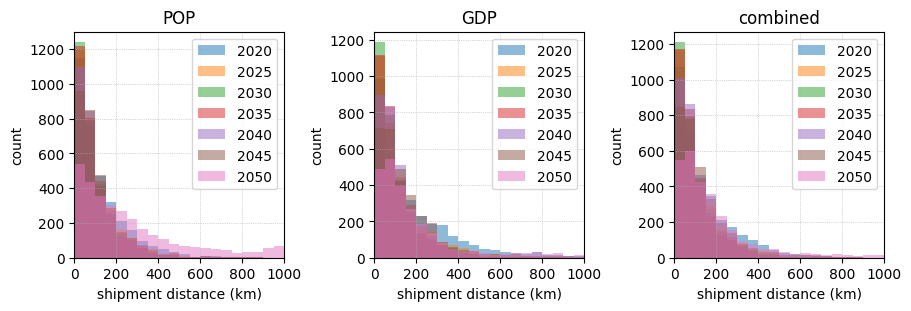

In [41]:
fig = plt.figure(figsize=(9, 3), constrained_layout=True)

for i, scenario in enumerate(['POP', 'GDP', 'combined']):
    axx = plt.subplot(1, 3, i+1)
    bin_edges = np.linspace(0, 2e3, num=41)
    for t in range(2020, 2055, 5):
        axx.hist(county_distance_matrix[np.where(names[f'shipment_matrix_{t}_{scenario}'].values > 0)], bins=bin_edges, alpha=0.5, label=t) 

    axx.set(title=scenario, xlim=(0, 1e3), xlabel='shipment distance (km)', ylabel='count')
    axx.legend(loc='best')
    axx.grid('on', ls=':', lw=0.5)

plt.show()
fig.savefig('../figures/shipment_distance_distribution.png', dpi=600, bbox_inches='tight')

In [42]:
for scenario in ['POP', 'GDP', 'combined']:
    names[f'national_results_{scenario}'] = pd.DataFrame([], index=all_county_set_POP[0].results.index, columns=['production', 'old capacity', 'new capacity', 'retired capacity', 'shutdown capacity'], dtype=np.float32) 
    names[f'national_results_{scenario}']['production'] = np.sum([a_county.results['production'] for a_county in names[f'all_county_set_{scenario}']], axis=0) / 1e3              # unit: Mt/year 
    names[f'national_results_{scenario}']['total capacity'] = np.sum([a_county.results['capacity'] for a_county in names[f'all_county_set_{scenario}']], axis=0) / 1e3              # unit: Mt/year 
    names[f'national_results_{scenario}']['old capacity'] = np.sum([a_county.results['old'] for a_county in names[f'all_county_set_{scenario}']], axis=0) / 1e3              # unit: Mt/year 
    names[f'national_results_{scenario}']['new capacity'] = np.sum([a_county.results['new'] for a_county in names[f'all_county_set_{scenario}']], axis=0) / 1e3              # unit: Mt/year 
    names[f'national_results_{scenario}']['retired capacity'] = np.sum([a_county.results['retired'] for a_county in names[f'all_county_set_{scenario}']], axis=0) / 1e3      # unit: Mt/year 
    names[f'national_results_{scenario}']['shutdown capacity'] = np.sum([a_county.results['shutdown'] for a_county in names[f'all_county_set_{scenario}']], axis=0) / 1e3    # unit: Mt/year 
    names[f'national_results_{scenario}'] = names[f'national_results_{scenario}'].round(1)


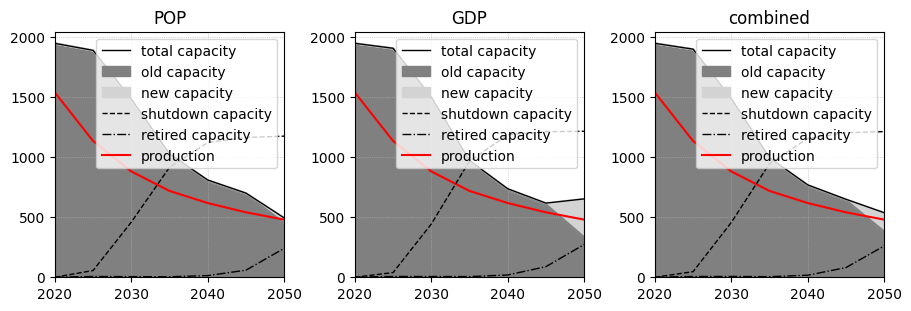

In [43]:
fig = plt.figure(figsize=(9, 3), constrained_layout=True)

for i, scenario in enumerate(['POP', 'GDP', 'combined']):
    axx = plt.subplot(1, 3, i+1)
    names[f'national_results_{scenario}'].plot(y=['total capacity'], color=['k'], lw=1.0, zorder=5, ax=axx)
    names[f'national_results_{scenario}'].plot.area(y=['old capacity', 'new capacity'], color=['grey', 'lightgrey'], xlim=(2020, 2050), ax=axx)
    names[f'national_results_{scenario}'].plot(y=['shutdown capacity'], color=['k'], ls='--', lw=1.0, zorder=5, ax=axx)
    names[f'national_results_{scenario}'].plot(y=['retired capacity'], color=['k'], ls='-.', lw=1.0, zorder=5, ax=axx)
    names[f'national_results_{scenario}'].plot(y=['production'], color=['r'], xlim=(2020, 2050), ax=axx)
    axx.set(title=scenario)
    axx.grid('on', lw=0.5, ls=':')
    axx.legend(loc='best', fontsize=10)

plt.show()

In [44]:
for scenario in ['POP', 'GDP', 'combined']:
    for t in range(2020, 2055, 5):
        hh_ = np.array([a_county.results.loc[t, 'production'] for a_county in names[f'all_county_set_{scenario}']])
        ii_ = np.array([a_county.results.loc[t, 'capacity'] for a_county in names[f'all_county_set_{scenario}']])
        hh = np.where(hh_ > 0, hh_, np.nan)
        ii = np.where(ii_ > 0, ii_, np.nan)
        China_counties[f'production_{t}_{scenario}'] = hh
        China_counties[f'capacities_{t}_{scenario}'] = ii

In [47]:
China_counties[['省', '市', '县', '县代码', 'production_2020_POP', 'production_2025_POP', 'production_2030_POP', 'production_2035_POP', 'production_2040_POP', 'production_2045_POP', 'production_2050_POP']].to_csv('../outputs/China_county_production_POP.csv', index=False, encoding='utf-8-sig')
China_counties[['省', '市', '县', '县代码', 'production_2020_GDP', 'production_2025_GDP', 'production_2030_GDP', 'production_2035_GDP', 'production_2040_GDP', 'production_2045_GDP', 'production_2050_GDP']].to_csv('../outputs/China_county_production_GDP.csv', index=False, encoding='utf-8-sig')
China_counties[['省', '市', '县', '县代码', 'production_2020_combined', 'production_2025_combined', 'production_2030_combined', 'production_2035_combined', 'production_2040_combined', 'production_2045_combined', 'production_2050_combined']].to_csv('../outputs/China_county_production_combined.csv', index=False, encoding='utf-8-sig')

In [48]:
China_counties[['省', '市', '县', '县代码', 'capacities_2020_POP', 'capacities_2025_POP', 'capacities_2030_POP', 'capacities_2035_POP', 'capacities_2040_POP', 'capacities_2045_POP', 'capacities_2050_POP']].to_csv('../outputs/China_county_capacity_POP.csv', index=False, encoding='utf-8-sig')
China_counties[['省', '市', '县', '县代码', 'capacities_2020_GDP', 'capacities_2025_GDP', 'capacities_2030_GDP', 'capacities_2035_GDP', 'capacities_2040_GDP', 'capacities_2045_GDP', 'capacities_2050_GDP']].to_csv('../outputs/China_county_capacity_GDP.csv', index=False, encoding='utf-8-sig')
China_counties[['省', '市', '县', '县代码', 'capacities_2020_combined', 'capacities_2025_combined', 'capacities_2030_combined', 'capacities_2035_combined', 'capacities_2040_combined', 'capacities_2045_combined', 'capacities_2050_combined']].to_csv('../outputs/China_county_capacity_combined.csv', index=False, encoding='utf-8-sig')